In [1]:
%load_ext Cython

In [2]:
%%cython -c=-ffast-math -a


### imports for calculation ###
from __future__ import division

import parameters
import numpy as np
import random as random
cimport numpy as np
cimport cython

from numpy cimport abs
from scipy import constants
from libcpp cimport bool
from libc.math cimport exp
from libc.math cimport sin
from libc.math cimport cos
from libc.math cimport acos
from libc.math cimport sqrt
from libc.math cimport M_PI
from libc.stdlib cimport rand
from libc.stdlib cimport rand

cdef extern from "limits.h":
    int RAND_MAX
    
## @cython.boundscheck(False)  # turn off bounds-checking for entire function
## @cython.wraparound(False)   # turn off negative index wrapping for entire function
## @cython.nonecheck(False)    # Turn off nonecheck locally for the function   

###############################################################################
#     random_lattice creates a randomly oriented NxN array

#     Args:
#         N (int) : dimension of array or lattice, i.e. NxN
#         u1 (double) : unit vector for 3d rotation matrix about a vector
#         u2 (double) : unit vector for 3d rotation matrix about a vector
#         theta (double) : list of arbitary angles [0, 2pi], used for monte carlo proposed rotation 
#         L (array) : NxN array of 3x1 arrays, i.e. NxN lattice with 3x1 vector valued entires 
#         a (int) : used to keep track array element (array elements represent lattice sites, which have alternating axis)
#         b (int) : same use as a
#         k (int) : used to keep track of current element in theta 

#     Returns:
#         L (array) : after entire array is iterated through, return lattice with vector elements with alternating axes 
################################################################################


@cython.boundscheck(False)
@cython.wraparound(False) 
@cython.nonecheck(False)  

cdef random_lattice(int N, double[:] u1, double[:] u2):   
    
    cdef double[::1] theta =  np.random.uniform(0,2*M_PI, N*N) 

    cdef np.ndarray[:,:] L = np.array(np.zeros((N,N), dtype=np.ndarray))
    
    cdef int a = 0
    cdef int b = 0
    cdef int k = 0
    temp = False
    
    for i in range(N):
        for j in range(N):   
            if a % 2 == 0:
                L[i,j] = rotation(theta, k, True, u1, u2).dot(u2) 
            else:
                L[i,j] = rotation(theta, k, False, u1, u2).dot(u1)
                
            if (a+1+b) % N == 0 and a != 0 and temp == False: 
                temp = True
                b = b + 1
            else:
                a = a + 1
                temp = False
            k += 1
  
    return L


###############################################################################
#     This function acts as a vector rotation about some unit vector for each vector element passed to it

#     Args:
#         theta (double) : list of arbitary angles [0, 2pi], used for monte carlo proposed rotation
#         c (bool) : used to keep track array element (array elements represent lattice sites, which have alternating axis)
#         u1 (array double) : unit vector for 3d rotation matrix about a vector
#         u2 (array double) : unit vector for 3d rotation matrix about a vector
#         C (array double) : cos function
#         S (array double) : sin function
#         t (array double) : 1-cos function

#     Returns:
#         None
################################################################################
@cython.boundscheck(False)
@cython.wraparound(False)
@cython.nonecheck(False)
cdef rotation(double[::1] theta, int i, np.npy_bool c, double[:] u1, double[:] u2):
    
    cdef double C = cos(theta[i])
    cdef double S = sin(theta[i])
    cdef double t = (1-cos(theta[i]))
    

    if c == True:
        return np.array([[C+(u1[0]**2)*t, u1[0]*u1[1]*t, u1[1]*S], 
                       [u1[1]*u1[0]*t, C+(u1[1]**2)*t, -u1[0]*S], [-u1[1]*S, u1[0]*S, C]])

    else:
        return np.array([[C+(u2[0]**2)*t, u2[0]*u2[1]*t, u2[1]*S], 
                       [u2[1]*u2[0]*t, C+(u2[1]**2)*t, -u2[0]*S], [-u2[1]*S, u2[0]*S, C]])
    
    

###############################################################################
#     This function calculates a unit vector

#     Args:
#         vector (double array) : 3x1 array element 

#     Returns:
#         unit vector value of passed in vector
################################################################################
@cython.boundscheck(False)
@cython.wraparound(False)
@cython.nonecheck(False)
cdef unit_vector(vector):
    return vector / np.linalg.norm(vector)


###############################################################################
#     This function takes two vectors and returns the angle between them

#     Args:
#         v1 (double array) : 3x1 array element 
#         v2 (double array) : 3x1 array element 

#     Returns:
#         angle between passed in vectors
################################################################################
@cython.boundscheck(False)
@cython.wraparound(False)
@cython.nonecheck(False)
cdef angle_between(v1, v2):
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return acos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))
    

###############################################################################
#     This function steps through each element of array, i.e. steps through each lattice site 

#     Args:
#         L (array of double arrays) : NxN array of 3x1 arrays, i.e. NxN lattice with 3x1 vector valued entires 
#         beta (float) : 1 / temperature 
#         N (int) : dimension of array
#         r1 (int array) : unit vector in -j direction, i.e. first nearest neighbor
#         r2 (int array) : unit vector in j direction, i.e. first nearest neighbor
#         r3 (int array) : unit vector in -i direction, i.e. first nearest neighbor
#         r4 (int array) : unit vector in i direction, i.e. first nearest neighbor
#         r1_2 (int array) : unit vector in -j, -i direction, i.e. second nearest neighbor
#         r1_2 (int array) : unit vector in j, -i direction, i.e. second nearest neighbor
#         r1_2 (int array) : unit vector in -j, i direction, i.e. second nearest neighbor
#         r1_2 (int array) : unit vector in j, i direction, i.e. second nearest neighbor
#         u1 (array double) : unit vector for 3d rotation matrix about a vector
#         u2 (array double) : unit vector for 3d rotation matrix about a vector
#         g (int) : keep track of theta element
#         theta (double array) : array of angle elements [0, 2p]
#         n (int) : nth element for i lattice elements
#         m (int) : mth element for j lattice elements
#         i (int) : keeps track of array element for alternating axis
#         k (int) : keeps track of array element for alternating axis
#         temp (bool) : keeps track of array element for alternating axis

#     Returns:
#         L updated lattice after calculation is made
################################################################################
@cython.boundscheck(False)
@cython.wraparound(False)
@cython.nonecheck(False)
cdef cy_aa_step(np.ndarray[:,::1] L, float beta, int N, int[:] r1, int[:] r2, int[:] r3, int[:] r4, 
                double[:] r1_2, double[:] r2_2, double[:] r3_2, double[:] r4_2, double[:] u1, double[:] u2):

    cdef int g = 0
    cdef double[::1] theta = np.random.uniform(0,2*M_PI, N*N)
    cdef int n, m
    cdef int i = 0
    cdef int k = 0
    temp = False
    for n in range(N):
        for m in range(N):
            cy_aa_update(L, N, n, m, beta, i, g, r1, r2, r3, r4, r1_2, r2_2, r3_2, r4_2, theta, u1, u2)
            if (i+1+k) % N == 0 and i != 0 and temp == False:
                temp = True
                k = k + 1
            else:
                i = i + 1
                temp = False
            g += 1
    return L


###############################################################################
#     This function updates each lattice site with a probability of remaining in the same orientation or 
#     being in a new orientation for each lattice site based on the boltzmann distribution 

#     Args:
#         L (array of double arrays) : NxN array of 3x1 arrays, i.e. NxN lattice with 3x1 vector valued entires 
#         beta (float) : 1 / temperature 
#         N (int) : dimension of array
#         r1 (int array) : unit vector in -j direction, i.e. first nearest neighbor
#         r2 (int array) : unit vector in j direction, i.e. first nearest neighbor
#         r3 (int array) : unit vector in -i direction, i.e. first nearest neighbor
#         r4 (int array) : unit vector in i direction, i.e. first nearest neighbor
#         r1_2 (int array) : unit vector in -j, -i direction, i.e. second nearest neighbor
#         r1_2 (int array) : unit vector in j, -i direction, i.e. second nearest neighbor
#         r1_2 (int array) : unit vector in -j, i direction, i.e. second nearest neighbor
#         r1_2 (int array) : unit vector in j, i direction, i.e. second nearest neighbor
#         u1 (array double) : unit vector for 3d rotation matrix about a vector
#         u2 (array double) : unit vector for 3d rotation matrix about a vector
#         g (int) : keep track of theta element
#         theta (double array) : array of angle elements [0, 2p]
#         n (int) : nth element for i lattice elements
#         m (int) : mth element for j lattice elements
#         i (int) : keeps track of array element for alternating axis
#         r (array of doubles) : proposed random vector orientation
#         H1_i (float) : Hamiltonian for nearest neighbor in -j direction
#         H2_i (float) : Hamiltonian for nearest neighbor in j direction
#         H3_i (float) : Hamiltonian for nearest neighbor in -i direction
#         H4_i (float) : Hamiltonian for nearest neighbor in i direction
#         H1_2i (float) : Hamiltonian for 2nd nearest neighbor in -j, -i direction
#         H2_2i (float) : Hamiltonian for 2nd nearest neighbor in j, -i direction
#         H3_2i (float) : Hamiltonian for 2nd nearest neighbor in -j, i direction
#         H4_2i (float) : Hamiltonian for 2nd nearest neighbor in j, i direction
#         lp (float array) : nth array element with z component equal to zero
#         rp (float array) : nth array element with z component equal to zero
#         tl (float) : angle between nth array element and ab plane
#         tr (float) : angle between proposed vector and ab plane
#         rotp (float) : rotational barrier coefficient 
#         H_i (flaot) : sum of hamiltonians from current lattice configuration
#         H_f (float) : sum of hamiltonians from proposed lattice configuration
#         H (float) : H_f - H_i
#     Returns:
#         None 
################################################################################
@cython.boundscheck(False)
@cython.wraparound(False)
@cython.nonecheck(False)
cdef cy_aa_update(np.ndarray[:,::1] L, int N, int n, int m, float beta, int i, int g, 
                  int[:] r1, int[:] r2, int[:] r3, int[:] r4, double[:] r1_2, 
                  double[:] r2_2, double[:] r3_2, double[:] r4_2, double[::1] theta, double[:] u1, double[:] u2):
    
    if (i)%2 == 0:
        c = True
    else:
        c = False
                
    r = rotation(np.asarray([theta[g]]), 0, c, u1, u2).dot(L[n,m])
    
#initial
    #nearest neighbors
    cdef float H1_i = -1*(3*(L[n,m].dot(r1))*(L[(n + 1)%N,m].dot(r1))-(L[n,m].dot(L[(n + 1)%N, m])))
    cdef float H2_i = -1*(3*(L[n,m].dot(r2))*(L[(n - 1)%N, m].dot(r2))-(L[n,m].dot(L[(n - 1)%N, m])))
    cdef float H3_i = -1*(3*(L[n,m].dot(r3))*(L[n, (m + 1)%N].dot(r3))-(L[n,m].dot(L[n, (m + 1)%N])))
    cdef float H4_i = -1*(3*(L[n,m].dot(r4))*(L[n, (m - 1)%N].dot(r4))-(L[n,m].dot(L[n, (m - 1)%N])))
    #2nd nearest neighbors
    cdef float H1_2i = -1*(1/np.sqrt(2)**3)*(3*(L[n,m].dot(r1_2))*(L[(n + 1)%N, (m + 1)%N].dot(r1_2))-(L[n,m].dot(L[(n + 1)%N,(m + 1)%N])))
    cdef float H2_2i = -1*(1/np.sqrt(2)**3)*(3*(L[n,m].dot(r2_2))*(L[(n + 1)%N, (m - 1)%N].dot(r2_2))-(L[n,m].dot(L[(n + 1)%N, (m - 1)%N])))
    cdef float H3_2i = -1*(1/np.sqrt(2)**3)*(3*(L[n,m].dot(r3_2))*(L[(n - 1)%N, (m + 1)%N].dot(r3_2))-(L[n,m].dot(L[(n - 1)%N, (m + 1)%N])))
    cdef float H4_2i = -1*(1/np.sqrt(2)**3)*(3*(L[n,m].dot(r4_2))*(L[(n - 1)%N, (m - 1)%N].dot(r4_2))-(L[n,m].dot(L[(n - 1)%N, (m - 1)%N])))

#proposed
    #nearest neighbors
    cdef float H1_f = -1*(3*(r.dot(r1))*(L[(n + 1)%N,m].dot(r1))-(r.dot(L[(n + 1)%N, m])))
    cdef float H2_f = -1*(3*(r.dot(r2))*(L[(n - 1)%N, m].dot(r2))-(r.dot(L[(n - 1)%N, m])))
    cdef float H3_f = -1*(3*(r.dot(r3))*(L[n, (m + 1)%N].dot(r3))-(r.dot(L[n, (m + 1)%N])))
    cdef float H4_f = -1*(3*(r.dot(r4))*(L[n, (m - 1)%N].dot(r4))-(r.dot(L[n, (m - 1)%N])))
    #2nd nearest neighbors
    cdef float H1_2f = -1*(1/np.sqrt(2)**3)*(3*(r.dot(r1_2))*(L[(n + 1)%N, (m + 1)%N].dot(r1_2))-(r.dot(L[(n + 1)%N, (m + 1)%N])))
    cdef float H2_2f = -1*(1/np.sqrt(2)**3)*(3*(r.dot(r2_2))*(L[(n + 1)%N, (m - 1)%N].dot(r2_2))-(r.dot(L[(n + 1)%N, (m - 1)%N])))
    cdef float H3_2f = -1*(1/np.sqrt(2)**3)*(3*(r.dot(r3_2))*(L[(n - 1)%N, (m + 1)%N].dot(r3_2))-(r.dot(L[(n - 1)%N, (m + 1)%N])))
    cdef float H4_2f = -1*(1/np.sqrt(2)**3)*(3*(r.dot(r4_2))*(L[(n - 1)%N, (m - 1)%N].dot(r4_2))-(r.dot(L[(n - 1)%N, (m - 1)%N])))
    
    cdef np.float64_t[:] Lp = np.array(L[n,m])
    cdef np.float64_t[:] rp = np.array(r)
    Lp[2] = 0.0
    rp[2] = 0.0
    
    cdef double tl = np.array([angle_between(L[n,m], Lp)])
    cdef double tr = np.array([angle_between(r, rp)])

    cdef double rotp = parameters.rotational_potential

    cdef float H_i = H1_i + H2_i + H3_i + H4_i + H1_2i + H2_2i + H3_2i + H4_2i + rotp*sin(tl)
    cdef float H_f = H1_f+ H2_f + H3_f + H4_f + H1_2f + H2_2f + H3_2f + H4_2f + rotp*sin(tr)
    cdef float H = H_f - H_i

    if H <= 0:
        L[n, m] = r 

    elif rand() < RAND_MAX * exp(-beta * H):
        L[n, m] = r 
        
       
###############################################################################
#     This function calculates the staggered polarization for the lattice

#     Args:
#         L (array of double arrays) : NxN array of 3x1 arrays; NxN lattice of vectors
#         pol1 (double array) : keeps count of magnitude of polarization vector
#         i (int) : ith element of lattice
#         j (int) : jth element of lattice

#     Returns:
#         pol1 (double array) : polarization vector
################################################################################
@cython.boundscheck(False)
@cython.wraparound(False)
@cython.nonecheck(False)
cdef cy_polarization(np.ndarray[:,::1] L):

    cdef double[:] pol1 = np.array([0.0,0.0,0.0])
    cdef int i
    cdef int j    
    
    for i in range(L.shape[0]):
        for j in range(L.shape[1]):
            if i%2 == 0 and j%2 == 0:
                pol1 = pol1 + L[i,j]
            
    return pol1 


###############################################################################
#     main function; initializes variables and constants 

#     Args:
#         N (int) : dimension of array
#         temp_points (int) : number of temperature values to use during calcuation
#         T (flaot array) : actual temperature values in a range
#         absP1 (float array) : will hold unity polarization values for each temperture point
#         eqsteps (int) : number of steps for equalibration 
#         mcsteps (int) : number of steps for measurement 
#         mc (float) : number of steps for measurement; used in finding average values
#         n1 (flaot) : used to calcuate average given lattice size and number of measurement steps

#     Returns:
#         x (str) : how long the calculation took in minutes
#         T (float array) : actual temerature values in a range
#         absP1 (float array) : holds unity polarization values for each temperature
#         N (int) : dimension of array
#         eqsteps (int) : number of steps for equalibration
#         mcsteps (int) : number of steps for measurement
################################################################################
@cython.boundscheck(False)
@cython.wraparound(False)
@cython.nonecheck(False)
def main():
    ## PARAMETERS
    cdef int N = parameters.N                          #size of lattice
    cdef int temp_points = parameters.num_data_points  #number of temperature points
    cdef np.float64_t[:] T = np.linspace(parameters.l_range, parameters.r_range, temp_points, dtype=np.float64)
    cdef np.float64_t[:] absP1 = np.zeros(temp_points, dtype=np.float64)
    
    cdef int eqsteps = parameters.equalibration_steps
    cdef int mcsteps = parameters.steps_to_average
    cdef float mc = 100
    cdef float n1 = 1.0/(mc*N*N)
    
    import time
    import sys
    cdef int a = 0
    cdef int h = 0
    cdef int p = 0
    
    cdef int[:] r2 = np.array([0,1,0], dtype = np.int32) 
    cdef int[:] r1 = np.array([0,-1,0], dtype = np.int32)
    cdef int[:] r3 = np.array([1,0,0], dtype = np.int32)
    cdef int[:] r4 = np.array([-1,0,0], dtype = np.int32)
    
    cdef double[:] r1_2 = np.array([1/np.sqrt(2),-1/np.sqrt(2),0])
    cdef double[:] r2_2 = np.array([-1/np.sqrt(2),-1/np.sqrt(2),0])
    cdef double[:] r3_2 = np.array([1/np.sqrt(2),1/np.sqrt(2),0])
    cdef double[:] r4_2 = np.array([-1/np.sqrt(2),1/np.sqrt(2),0])
    
    cdef double[:] u1 = np.array([1/sqrt(2),1/sqrt(2),0])
    cdef double[:] u2 = np.array([-1/sqrt(2),1/sqrt(2),0])
        
    cdef np.ndarray[:,::1] L
    cdef float b1 = 0.0
    cdef int i = 0
    start_time = time.clock()

    for p in range(len(T)):

        absp1 = np.array([0.0,0.0,0.0])
        L = random_lattice(N, u1, u2)
        b1 = 1.0 / T[p] 
        for i in range(eqsteps):
            cy_aa_step(L, b1, N, r1, r2, r3, r4, r1_2, r2_2, r3_2, r4_2, u1, u2)
            
        for i in range(mcsteps):
            cy_aa_step(L, b1, N, r1, r2, r3, r4, r1_2, r2_2, r3_2, r4_2, u1, u2)
            absp1 = cy_polarization(L) + absp1

        a += 1
        print(a) 
        
        absP1[p] = n1*np.linalg.norm(absp1)

    
    cdef float seconds = time.clock() - start_time
    cdef float minutes = 0
    cdef float hours = 0
    cdef str x = ''
    
    if seconds >= 60:
        minutes = seconds / 60.0
        seconds = seconds - int(minutes) * 60
    if minutes >= 60:
        hours = minutes / 60.0
        minutes = minutes - int(hours) * 60

    if hours > 0:
        x = 'Calculation took ' + str('%.0f' % hours) + ' hours, ' + str('%.0f' % minutes) + ' minutes and ' + str( '%.0f' % seconds) + " seconds."
    elif hours == 0 and minutes > 0:
        x = 'Calculation took ' + str('%.0f' % minutes) + ' minutes and ' + str( '%.0f' % seconds) + " seconds."
    else:
        x = 'Calculation took ' + str('%.0f' % seconds) + " seconds."
        
    return x, np.asarray(T), np.asarray(absP1), N, eqsteps, mcsteps
    

def display(x, T, absP1, N, eqsteps, mcsteps):
    import matplotlib.pyplot as plt

    f = plt.figure(figsize=(36, 20));   

    plt.title('-'+np.str(N)+'x'+np.str(N)+' lattice-' + ' ' + x,fontsize=50)

    plt.scatter(T, absP1, s=70, marker='o', color='IndianRed')
    plt.xticks(fontsize = 30);
    plt.yticks(fontsize = 30);
    plt.xlabel("Temperature (T)", fontsize=40);
    plt.ylabel("Pol1 ", fontsize=40);     plt.axis('tight');


In [3]:
values = main()

c:\users\v-staan\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """Entry point for launching an IPython kernel.


1
2
3
4
5
6
7
8
9
10


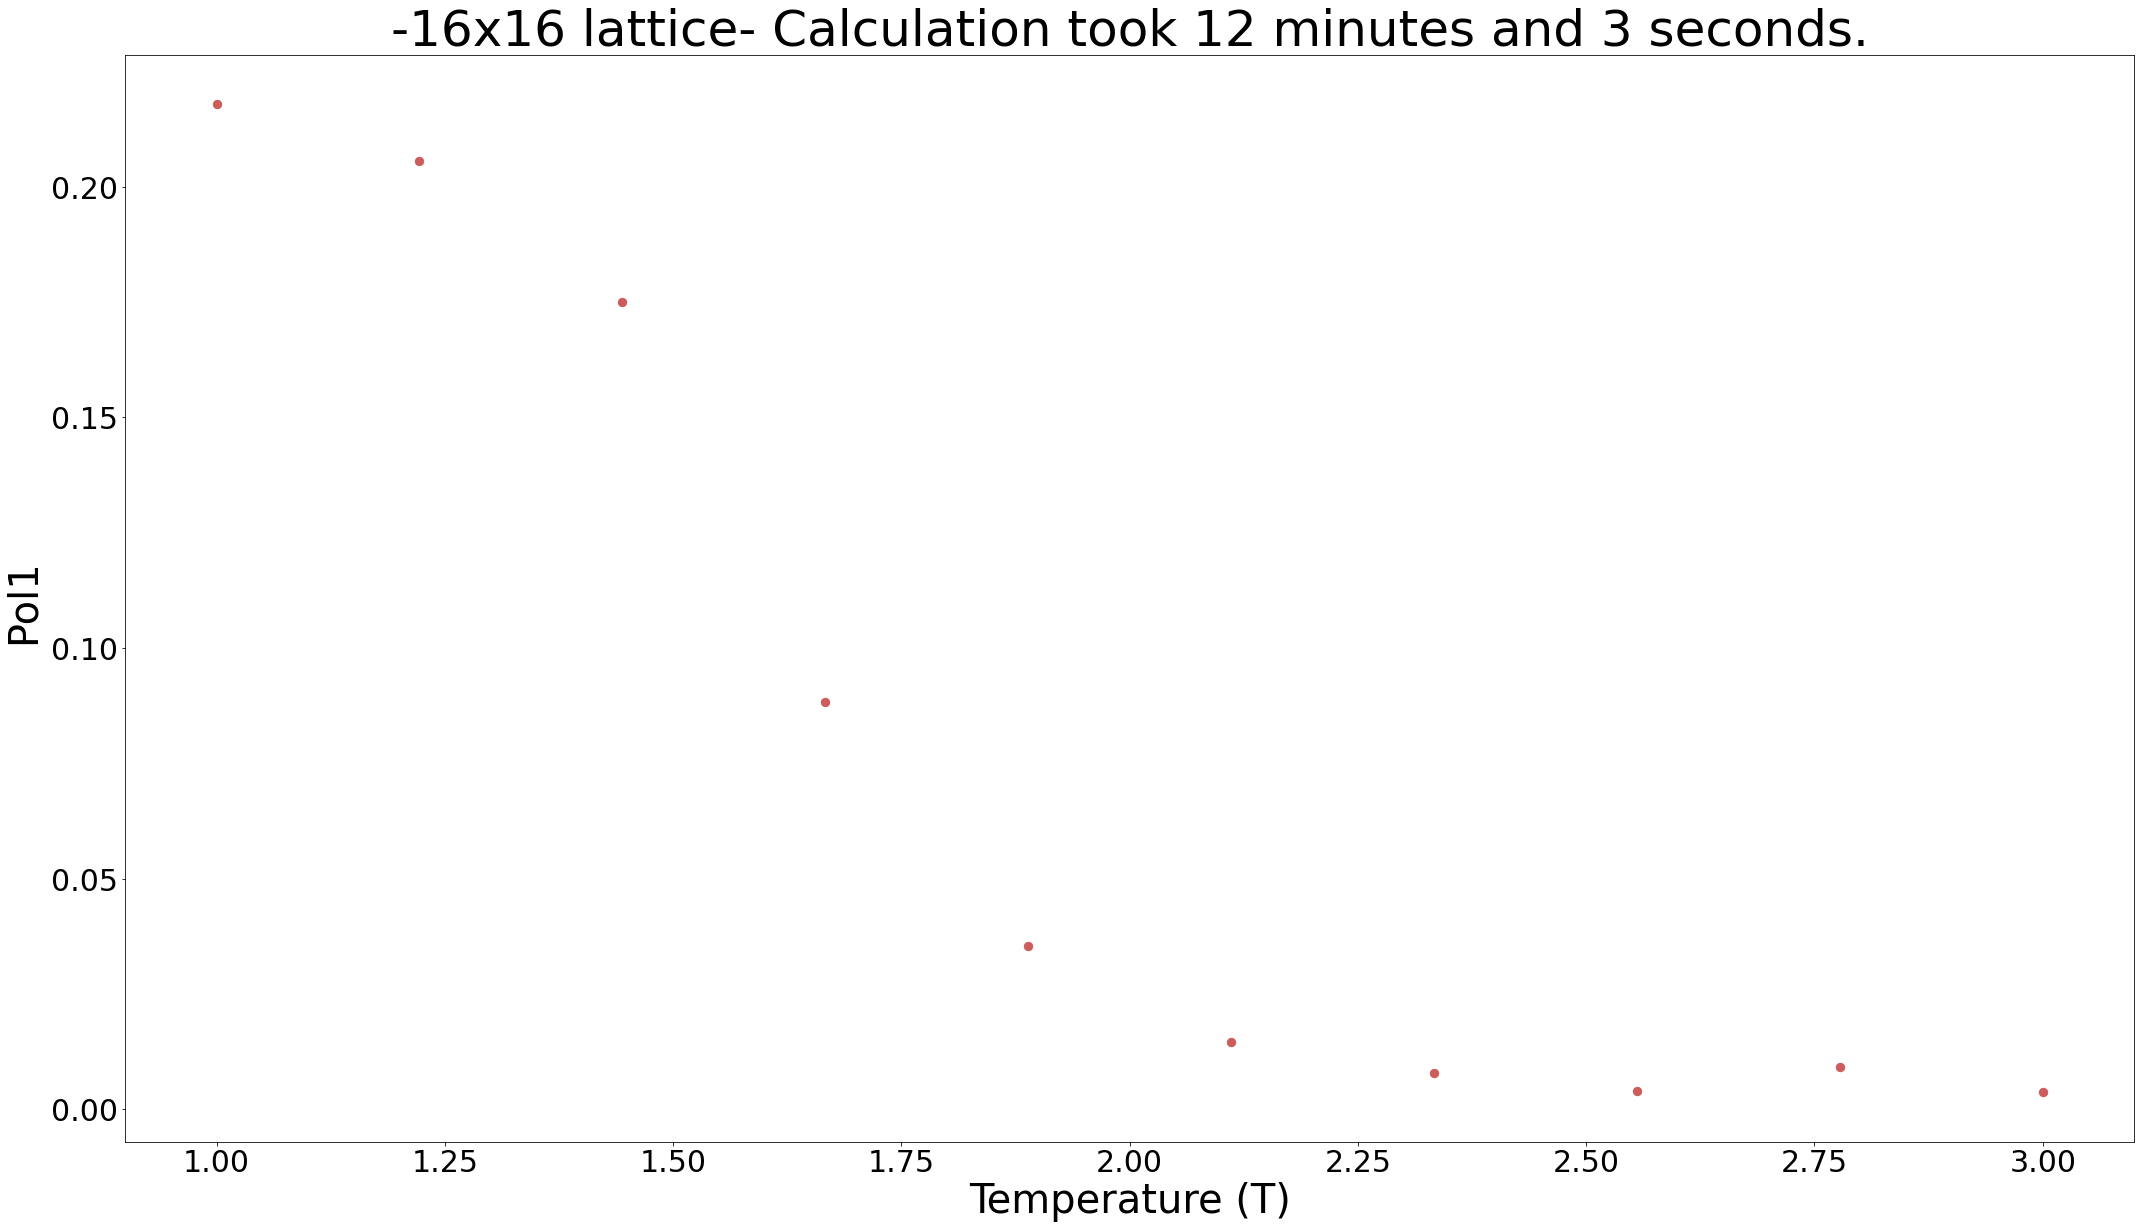

In [4]:
x=values[0]
T=values[1]
M1 = values[2]
N=values[3]
eqsteps=values[4]
mcsteps=values[5]

display(x, T, M1, N, eqsteps, mcsteps)